Zeynep Sena Yeşilyurt - 150230015

In [23]:
pip install osmnx

Note: you may need to restart the kernel to use updated packages.


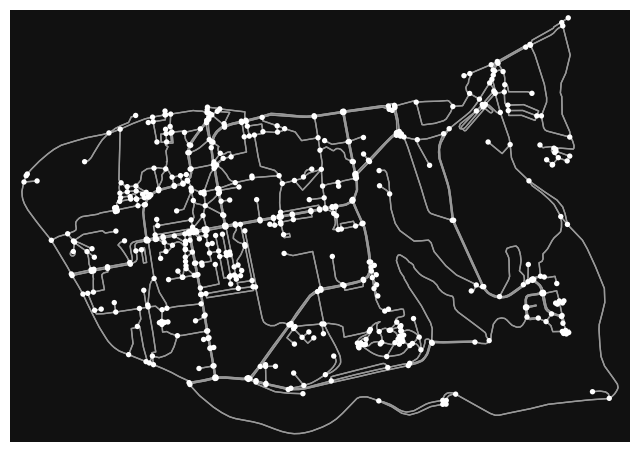

In [24]:
import numpy as np
import networkx as nx
import osmnx as ox

np.random.seed(42)  # Set random seed for reproducibility

# Load ITU campus graph
place_name = "Istanbul Teknik Universitesi, Sariyer, Istanbul, Turkey"
G = ox.graph_from_place(place_name, network_type='walk')
ox.plot_graph(G)

G = nx.Graph(G)
nodes = list(G.nodes)
# Adjacency matrix 
A = nx.to_numpy_array(G, nodelist=nodes)
# Degree matrix 
D = np.diag(np.sum(A, axis=1))
# Compute unnormalized Laplacian matrix

L = D - A


In [25]:
# Inverse power method to find smallest eigenvectors
def inverse_power_method_shifted(L, k, mu=1e-3, num_iter=1000, tol=1e-10):
    n = L.shape[0]
    I = np.eye(n)
    Q = np.zeros((n, k))

    for i in range(k):
        v = np.random.rand(n)
        v = v / np.linalg.norm(v)

        for _ in range(num_iter):
            w = np.linalg.solve(L - mu * I, v)
            for j in range(i):
                w = w - np.dot(Q[:, j], w) * Q[:, j]
            w = w / np.linalg.norm(w)
            if np.linalg.norm(w - v) < tol:
                break
            v = w

        Q[:, i] = w

    return Q


In [32]:
from sklearn.cluster import KMeans

# Get the number of clusters (k) from the user 
k = int(input("How many clusters (k) would you like? "))
U = inverse_power_method_shifted(L, k)
# Normalize eigenvectors row-wise
U_normalized = U / np.linalg.norm(U, axis=1, keepdims=True)
# Apply KMeans on spectral embedding
labels_spectral = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(U_normalized)

x_pos = nx.get_node_attributes(G, 'x')
y_pos = nx.get_node_attributes(G, 'y')
pos = {node: (x_pos[node], y_pos[node]) for node in G.nodes if node in x_pos and node in y_pos}
coords = np.array([pos[node] for node in nodes if node in pos])
# Apply KMeans on coordinate-based input
labels_coord = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(coords)


In [33]:
# Function to compute modularity
def compute_modularity(A, labels):
    m = np.sum(A) / 2
    degrees = np.sum(A, axis=1)
    Q = 0
    for i in range(len(A)):
        for j in range(len(A)):
            if labels[i] == labels[j]:
                Q += A[i][j] - (degrees[i] * degrees[j]) / (2 * m)
    return Q / (2 * m)

# Compute modularity for spectral clustering
mod_spec = compute_modularity(A, labels_spectral)
# Compute modularity for coordinate-based clustering
mod_coord = compute_modularity(A, labels_coord)

print(f"Spectral Modularity: {mod_spec:.4f}")
print(f"Coordinate-based Modularity: {mod_coord:.4f}")


Spectral Modularity: 0.7653
Coordinate-based Modularity: 0.7411


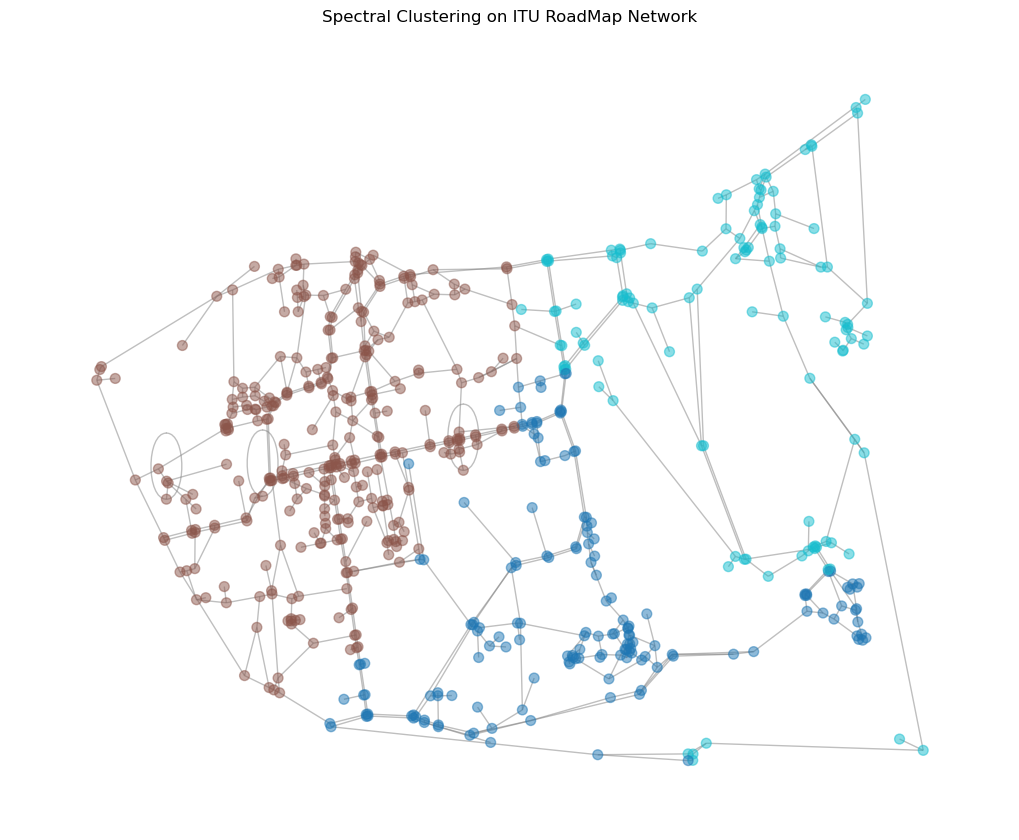

<Figure size 640x480 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt

x_pos = nx.get_node_attributes(G, 'x')
y_pos = nx.get_node_attributes(G, 'y')
pos = {node: (x_pos[node], y_pos[node]) for node in G.nodes if node in x_pos and node in y_pos}

#  Figure plotting
plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_color=labels_spectral, cmap=plt.cm.tab10,
        node_size=50, edge_color='gray', alpha=0.5)
plt.title("Spectral Clustering on ITU RoadMap Network")
plt.show()
plt.savefig(f"spectral_k{k}.png", dpi=300)



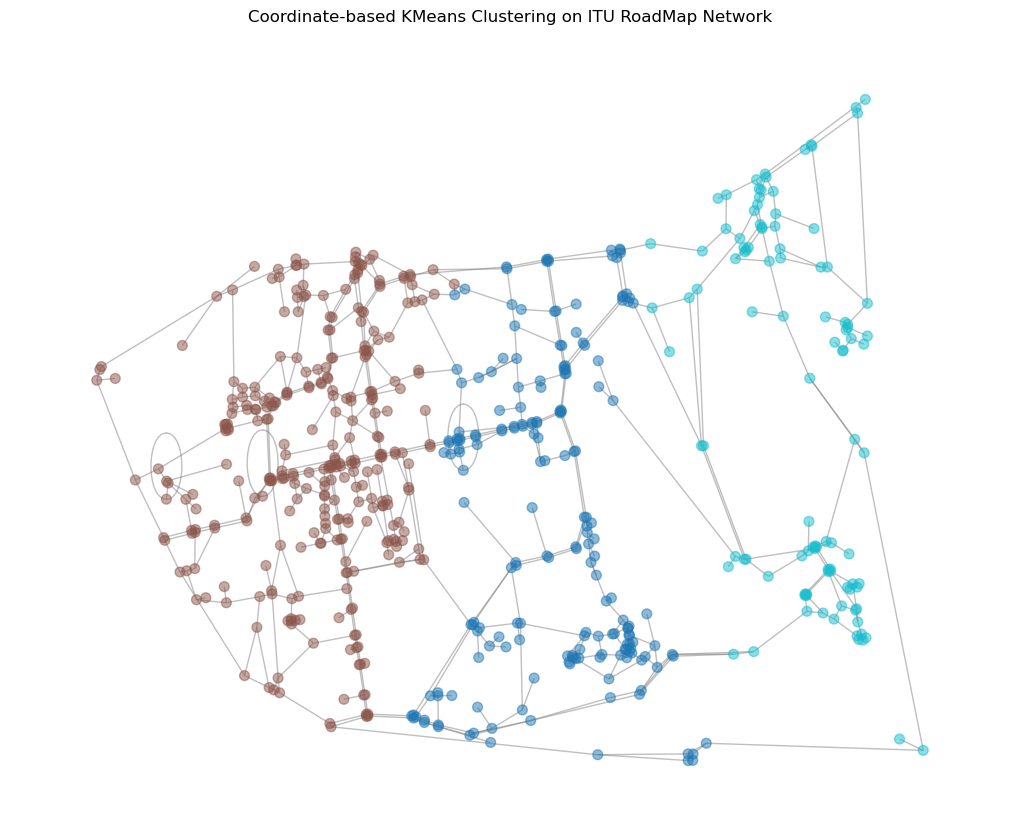

<Figure size 640x480 with 0 Axes>

In [29]:
plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_color=labels_coord, cmap=plt.cm.tab10,
        node_size=50, edge_color='gray', alpha=0.5)
plt.title("Coordinate-based KMeans Clustering on ITU RoadMap Network")
plt.show()
plt.savefig(f"coord_k{k}.png", dpi=300)


Calculate clustering and modularity scores, then plot the results for a range of k values


--- k = 2 ---
Spectral Modularity: 0.4726
Coordinate-based Modularity: 0.4604


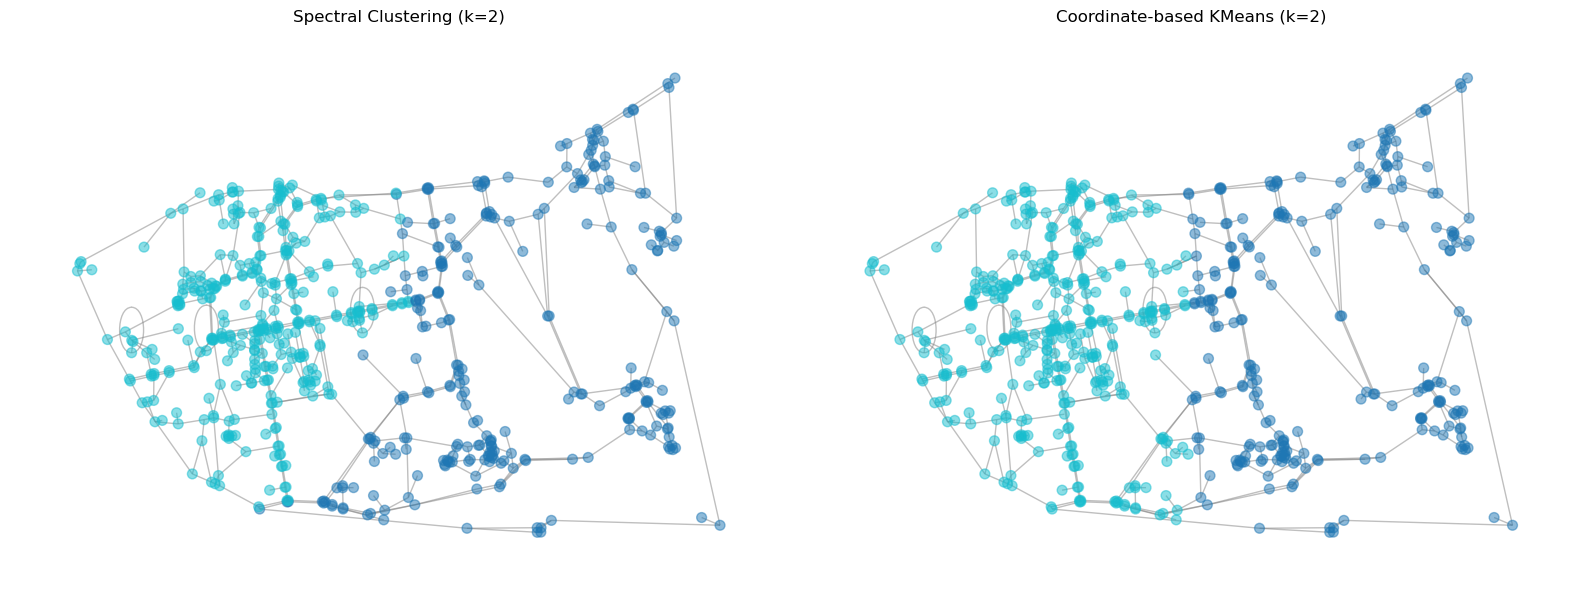


--- k = 3 ---
Spectral Modularity: 0.5725
Coordinate-based Modularity: 0.5805


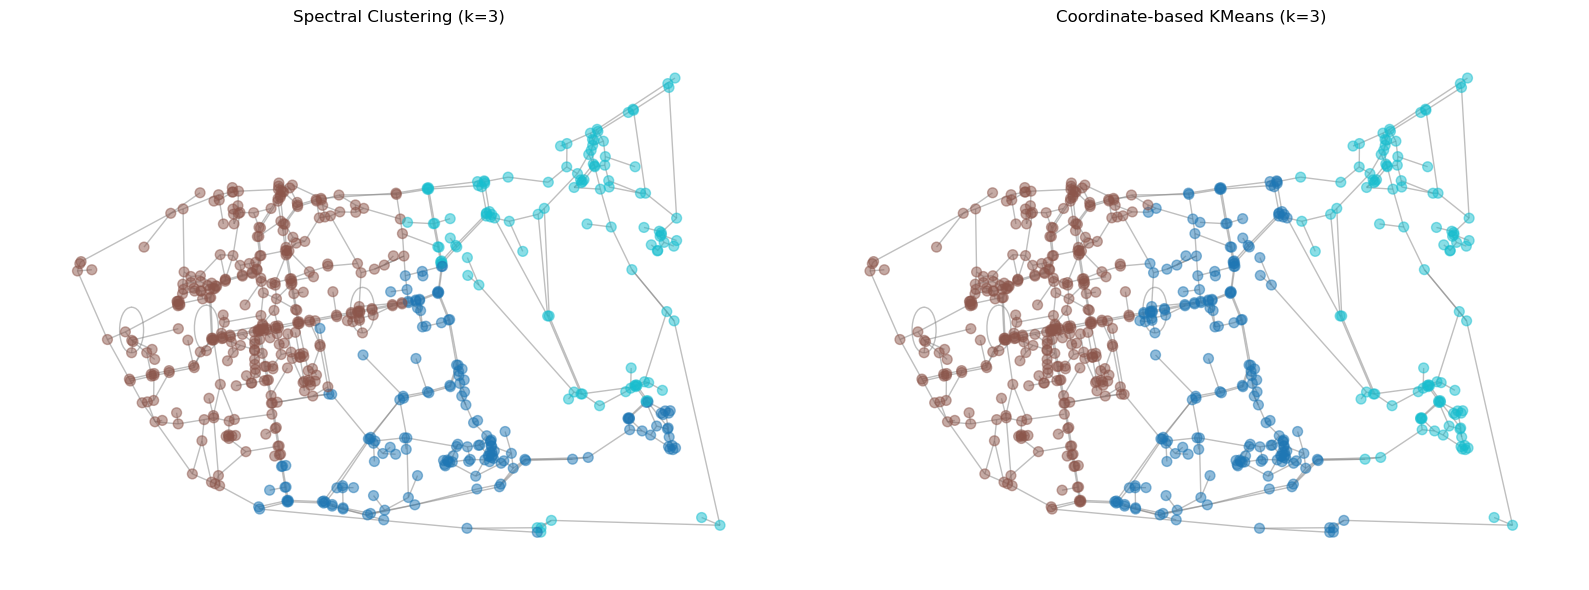


--- k = 4 ---
Spectral Modularity: 0.6868
Coordinate-based Modularity: 0.6482


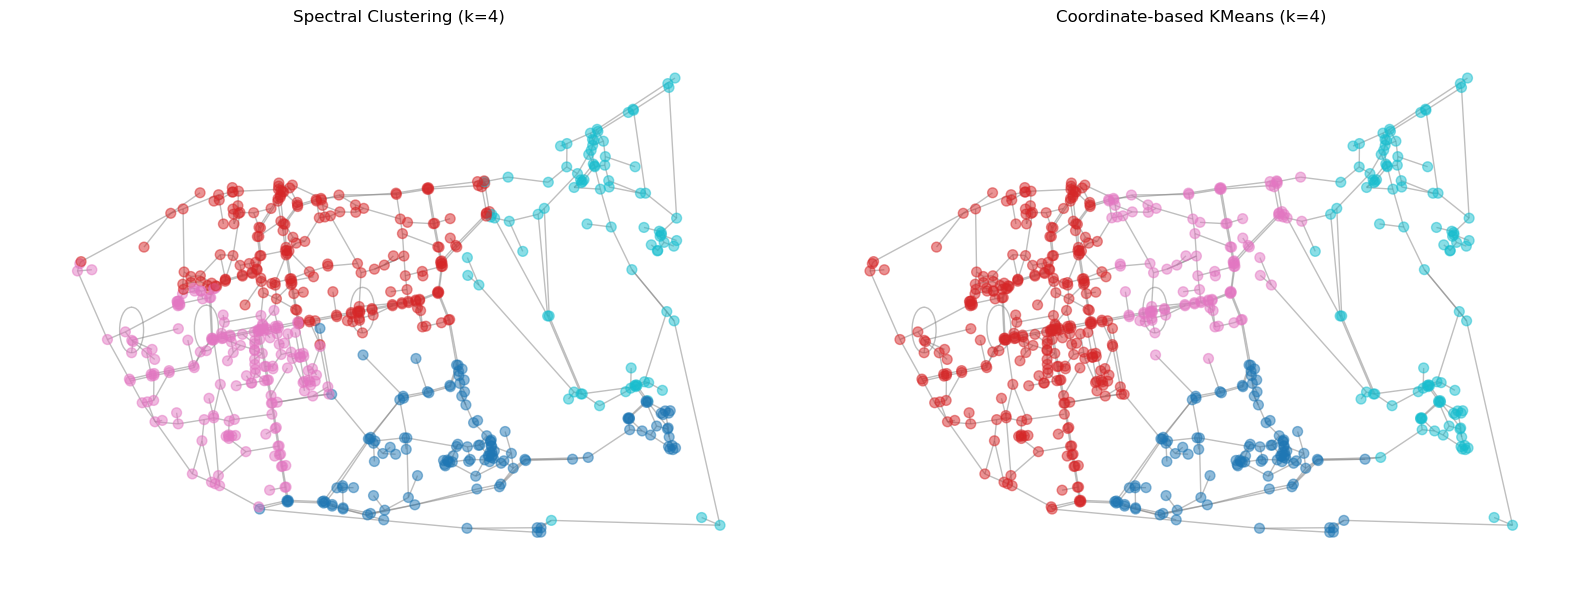


--- k = 5 ---
Spectral Modularity: 0.7482
Coordinate-based Modularity: 0.6562


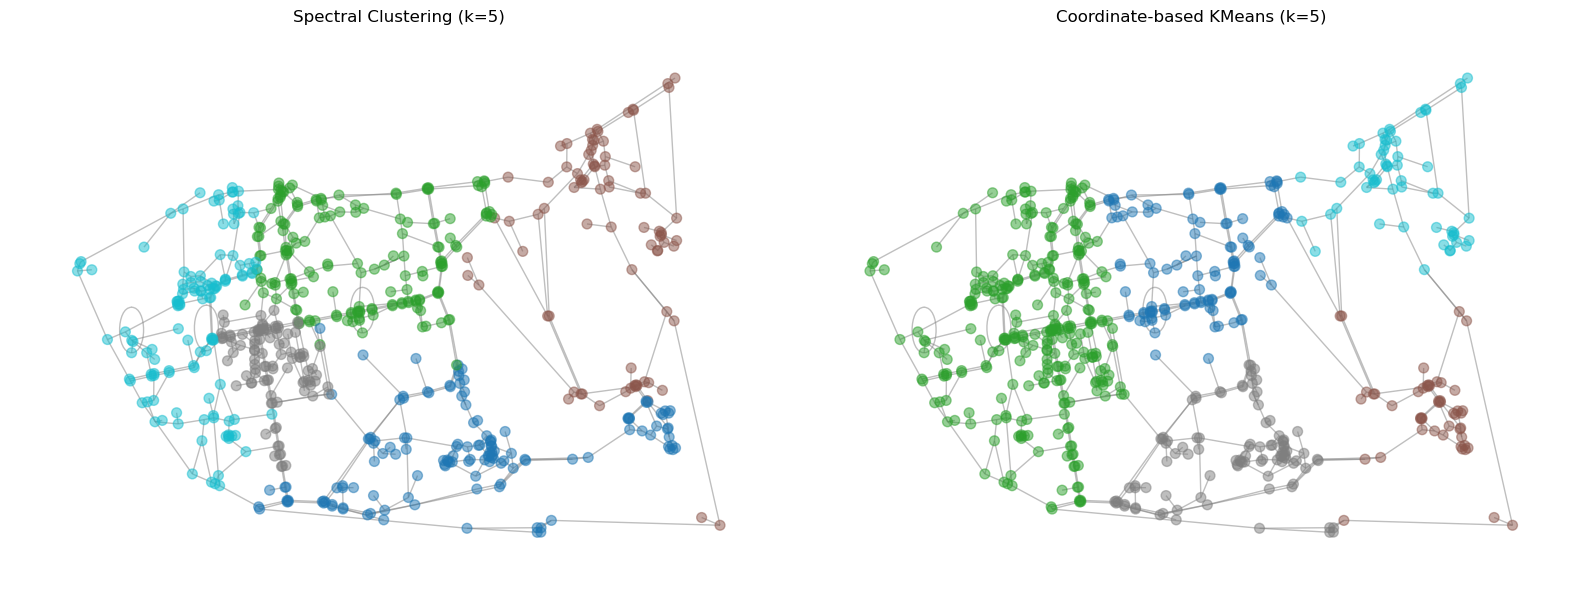


--- k = 6 ---
Spectral Modularity: 0.7653
Coordinate-based Modularity: 0.7411


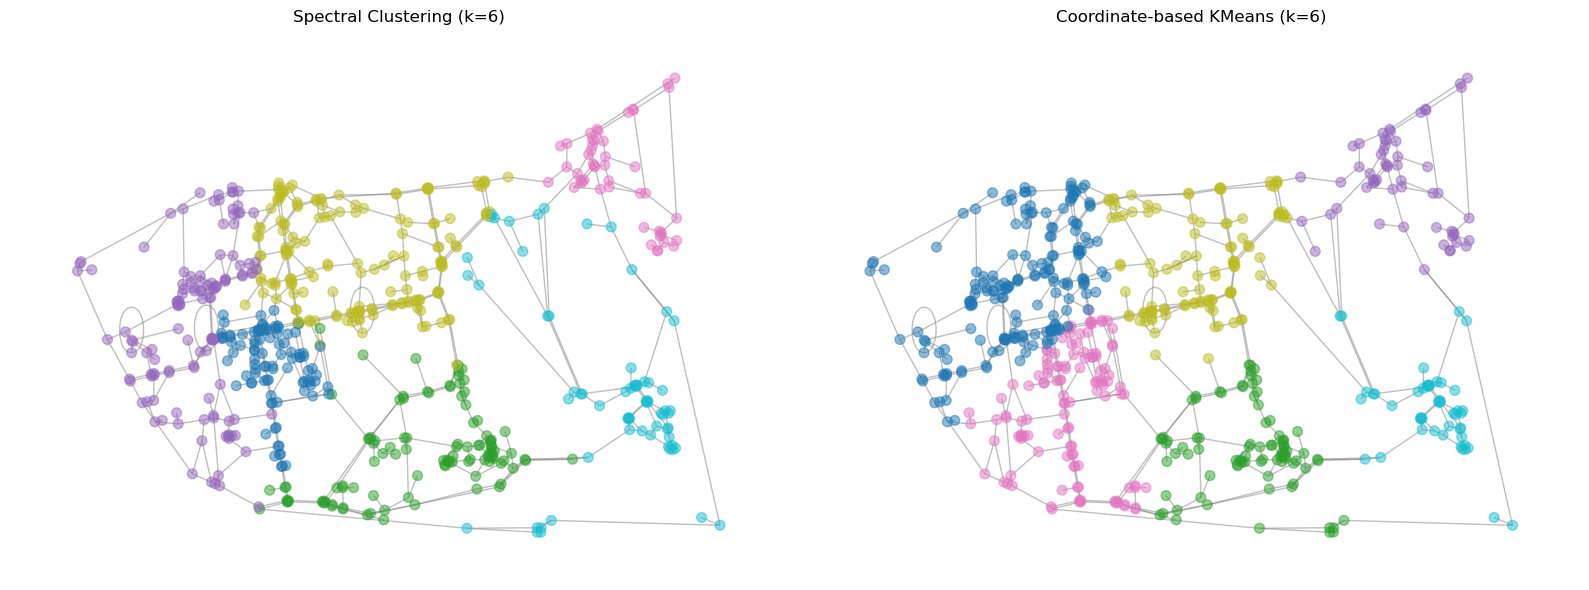

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans

# Rastgeleliği sabitle (hem power method hem KMeans için)
np.random.seed(42)

k_range = range(2, 7)
spectral_mods = []
coord_mods = []

for k in k_range:
    # Eigenvector hesapla (inverse power method ile)
    U = inverse_power_method_shifted(L, k)
    U_normalized = U / np.linalg.norm(U, axis=1, keepdims=True)

    # Clustering işlemleri (random_state ile sabitlenmiş)
    labels_spectral = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(U_normalized)
    labels_coord = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(coords)

    # Modularity hesapla
    mod_s = compute_modularity(A, labels_spectral)
    mod_c = compute_modularity(A, labels_coord)

    spectral_mods.append(mod_s)
    coord_mods.append(mod_c)

    # Sonuçları yazdır
    print(f"\n--- k = {k} ---")
    print(f"Spectral Modularity: {mod_s:.4f}")
    print(f"Coordinate-based Modularity: {mod_c:.4f}")
    
    # Grafik çiz ve kaydet
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    nx.draw(G, pos, node_color=labels_spectral, cmap=plt.cm.tab10,
            node_size=50, edge_color='gray', alpha=0.5, ax=axes[0])
    axes[0].set_title(f"Spectral Clustering (k={k})")

    nx.draw(G, pos, node_color=labels_coord, cmap=plt.cm.tab10,
            node_size=50, edge_color='gray', alpha=0.5, ax=axes[1])
    axes[1].set_title(f"Coordinate-based KMeans (k={k})")

    plt.tight_layout()
    plt.savefig(f"clustering_k{k}.png", dpi=300)
    plt.show()


Plot modularity scores for both methods to compare clustering performance across different k values

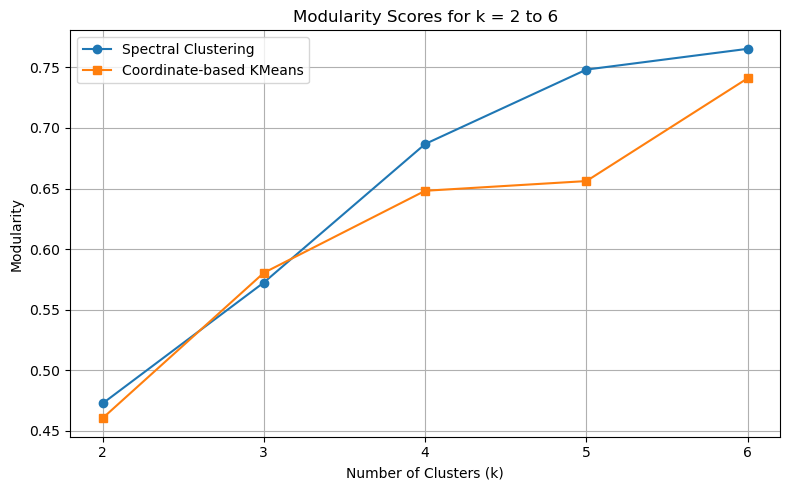

In [31]:
plt.figure(figsize=(8, 5))
plt.plot(list(k_range), spectral_mods, marker='o', label='Spectral Clustering')
plt.plot(list(k_range), coord_mods, marker='s', label='Coordinate-based KMeans')
plt.title('Modularity Scores for k = 2 to 6')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Modularity')
plt.xticks(list(k_range))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("modularity_graph.png", dpi=300)
plt.show()